In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# --- a. Import Required Libraries (Done above) ---
# --- b. Upload/Access the Dataset ---
# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# Flatten the images
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(f"Original training data shape: {x_train.shape}") # (60000, 784)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Original training data shape: (60000, 784)


In [4]:
# Define "normal" classes (e.g., T-shirts/tops, Trousers, Pullovers, Dress, Coat)
# Note: Adjust these based on desired anomaly definition.
normal_classes = [0, 1, 2, 3, 4] # T-shirt/top, Trouser, Pullover, Dress, Coat
# normal_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Use all classes for a basic autoencoder demo
# Filter training data to include only normal classes
idx_train_normal = np.isin(y_train, normal_classes)
x_train_normal = x_train[idx_train_normal]
y_train_normal = y_train[idx_train_normal] # Not used for training, but for reference
# Filter test data for normal and anomalous samples
idx_test_normal = np.isin(y_test, normal_classes)
x_test_normal = x_test[idx_test_normal]
y_test_normal = y_test[idx_test_normal]
idx_test_anomaly = ~idx_test_normal # "not normal"
x_test_anomaly = x_test[idx_test_anomaly]
y_test_anomaly = y_test[idx_test_anomaly]
print(f"Training data shape (normal only): {x_train_normal.shape}")
print(f"Test data shape (normal): {x_test_normal.shape}")
print(f"Test data shape (anomaly): {x_test_anomaly.shape}")
# --- c. The encoder converts it into a latent representation ---
input_dim = x_train_normal.shape[1] # 784
latent_dim = 32 # Size of the latent space
# Encoder
encoder_input = Input(shape=(input_dim,))

Training data shape (normal only): (30000, 784)
Test data shape (normal): (5000, 784)
Test data shape (anomaly): (5000, 784)


In [5]:
encoder_layer_1 = Dense(128, activation='relu')(encoder_input)
latent_representation = Dense(latent_dim, activation='relu')(encoder_layer_1)
encoder = Model(inputs=encoder_input, outputs=latent_representation, name="encoder")
# --- d. Decoder networks convert it back to the original input ---
# Decoder
decoder_input = Input(shape=(latent_dim,))
decoder_layer_1 = Dense(128, activation='relu')(decoder_input)
reconstructed_output = Dense(input_dim, activation='sigmoid')(decoder_layer_1) # Sigmoidfor [0,1] range
decoder = Model(inputs=decoder_input, outputs=reconstructed_output, name="decoder")
# Autoencoder = Encoder + Decoder
autoencoder_input = Input(shape=(input_dim,))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = Model(inputs=autoencoder_input, outputs=decoded_img,
name="autoencoder")
autoencoder.summary()
# --- e. Compile the models with Optimizer, Loss, and Evaluation Metrics ---
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
loss='mse') # Mean Squared Error for reconstruction loss

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 32)             │       104,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       105,360 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the autoencoder ONLY on normal data
print("\nTraining the autoencoder on normal data...")
history = autoencoder.fit(x_train_normal, x_train_normal, # Input and output are the same
epochs=200, # Reduced epochs for demonstration
batch_size=256,
shuffle=True,
validation_data=(x_test_normal, x_test_normal)) # Validate on normal test]'data



Training the autoencoder on normal data...
Epoch 1/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0098 - val_loss: 0.0104
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0096 - val_loss: 0.0098
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0094 - val_loss: 0.0098
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 9/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0092 - val_loss: 0.0094
Epoch 10/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 11/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0091 - val

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


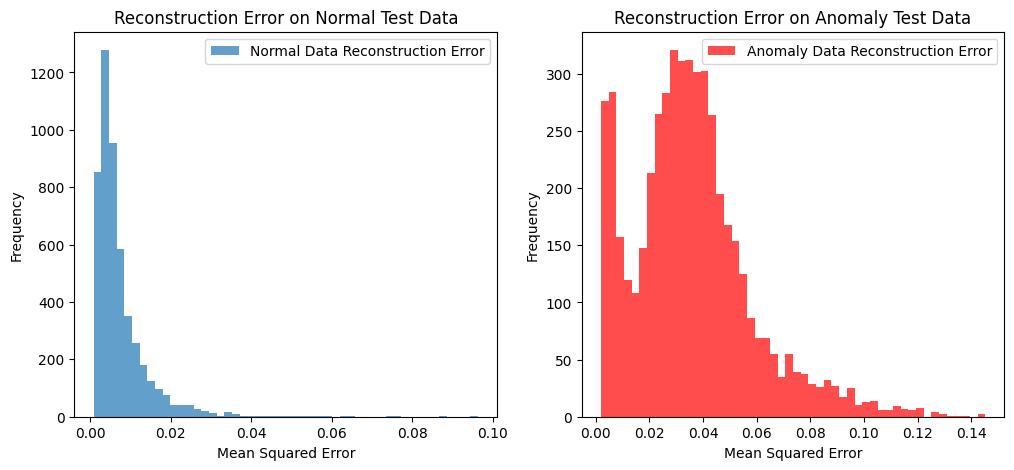

In [11]:
# Predict reconstructions for normal and anomalous test data
x_test_normal_pred = autoencoder.predict(x_test_normal)
x_test_anomaly_pred = autoencoder.predict(x_test_anomaly)
# Calculate reconstruction errors (MSE)
mse_normal = np.mean(np.power(x_test_normal - x_test_normal_pred, 2), axis=1)
mse_anomaly = np.mean(np.power(x_test_anomaly - x_test_anomaly_pred, 2), axis=1)
# Plotting reconstruction errors
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Data Reconstruction Error')
plt.title('Reconstruction Error on Normal Test Data')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(mse_anomaly, bins=50, alpha=0.7, label='Anomaly Data Reconstruction Error',
color='red')
plt.title('Reconstruction Error on Anomaly Test Data')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()

<Figure size 640x480 with 0 Axes>


Reconstruction threshold (95th percentile of normal errors): 0.019781

Number of normal samples misclassified as anomalies:250
Number of anomaly samples correctly detected:3871
Total anomaly samples: 5000


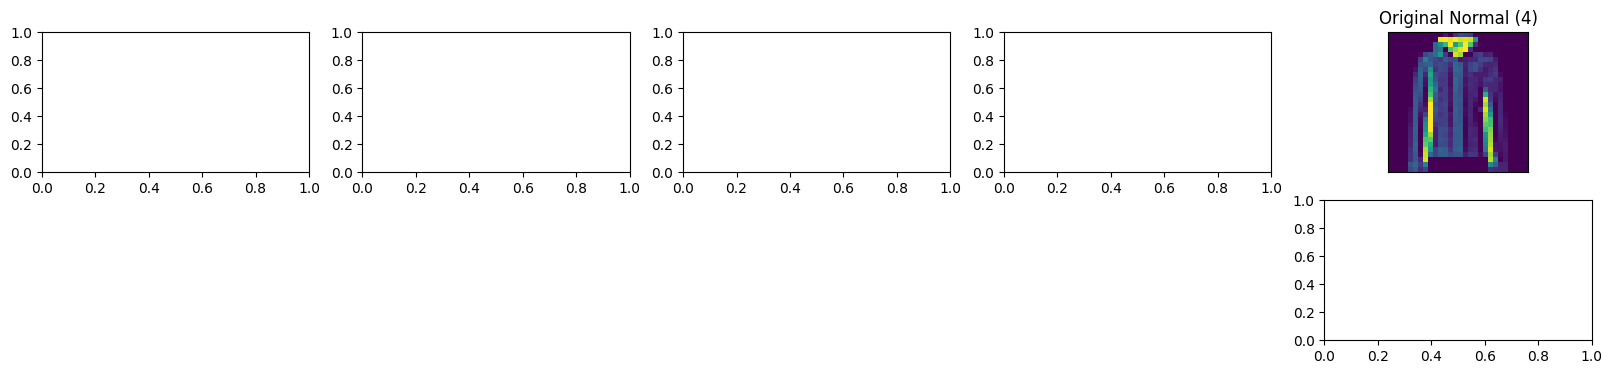

In [12]:
plt.tight_layout()
plt.show()
# Determine a threshold (e.g., based on the 95th percentile of normal errors)
threshold = np.percentile(mse_normal, 95)
print(f"\nReconstruction threshold (95th percentile of normal errors): {threshold:.6f}")
# Classify test data based on the threshold
anomalies_detected_normal = mse_normal > threshold
anomalies_detected_anomaly = mse_anomaly > threshold
print(f"\nNumber of normal samples misclassified as anomalies:{np.sum(anomalies_detected_normal)}")
print(f"Number of anomaly samples correctly detected:{np.sum(anomalies_detected_anomaly)}")
print(f"Total anomaly samples: {len(mse_anomaly)}")
# Visualize some reconstructions
n = 5 # Number of examples to visualize
plt.figure(figsize=(20, 4))
for i in range(n):
# Display original normal image
  ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test_normal[i].reshape(28, 28))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Original Normal ({y_test_normal[i]})")
# Display reconstructed normal image
ax = plt.subplot(2, n, i + 1 + n)


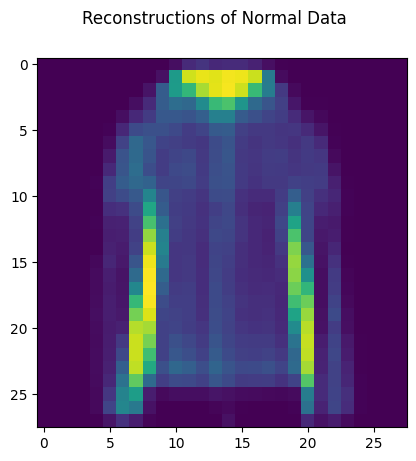

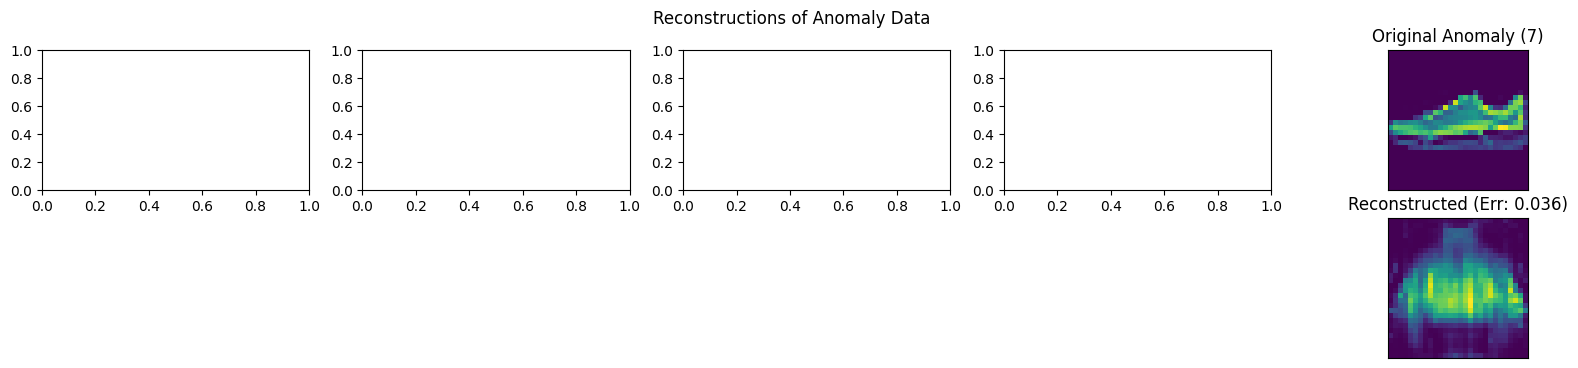

In [13]:
plt.imshow(x_test_normal_pred[i].reshape(28, 28))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Reconstructed (Err: {mse_normal[i]:.3f})")
plt.suptitle("Reconstructions of Normal Data")
plt.show()
plt.figure(figsize=(20, 4))
for i in range(n):
# Display original anomaly image
  ax = plt.subplot(2, n, i + 1)
plt.imshow(x_test_anomaly[i].reshape(28, 28))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Original Anomaly ({y_test_anomaly[i]})")
# Display reconstructed anomaly image
ax = plt.subplot(2, n, i + 1 + n)
plt.imshow(x_test_anomaly_pred[i].reshape(28, 28))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title(f"Reconstructed (Err: {mse_anomaly[i]:.3f})")
plt.suptitle("Reconstructions of Anomaly Data")
plt.show()